## Load outer libraries

In [2]:
import pandas as pd
import numpy as np
from __future__ import division
import matplotlib.pyplot as plt
import pickle
import seaborn as sns
sns.set(style="darkgrid")

%matplotlib inline

# Find optimal hyperparameters

In [3]:
import optunity
from sklearn.svm import SVC
from sklearn.metrics import cohen_kappa_score
from spikeHelper.dataOrganization import getX, XyTfromEpoch, trialToXyT

In [4]:
from spikeHelper.dataOrganization import loadBestParams
from spikeHelper.similarities import temporalGeneralization,crossGeneralization
from spikeHelper.metrics import performanceFromConfusion

In [50]:
def optimalPars(cubicData, cv=5):
    
    def svm_rbf_tuned_auroc(x_train, y_train, x_test, y_test, C, logGamma):
        model = SVC(C=C, gamma=10 ** logGamma).fit(x_train, y_train)
        y_pred = model.predict(x_test)
        auc = cohen_kappa_score(y_test, y_pred, weights='linear')
        return auc
    
    cvOptimal=pd.DataFrame(columns = ['logGamma','C'])
    for cvi in range(cv):
        # Get one time of each trial
        y_time = np.random.randint(cubicData.shape[1],size=cubicData.shape[2])
        X = np.array([cubicData[:,y_time[t],t] for t in range(cubicData.shape[2])])
        cv_decorator = optunity.cross_validated(x=X, y=y_time, num_folds=5)
        svm_rbf_tuned_auroc = cv_decorator(svm_rbf_tuned_auroc)
        optimal_rbf_pars, _, _ = optunity.maximize(svm_rbf_tuned_auroc, num_evals=50, C=[0, 40], logGamma=[-7,0])
        cvOptimal = pd.concat((cvOptimal,pd.DataFrame(optimal_rbf_pars,index=[1]) ) )
    return cvOptimal

In [51]:
allRatsOptimal = pd.DataFrame(columns = ['logGamma','C','Rat'])
for rat in [7,8,9,10]:
    data = pickle.load(open('Data/r'+str(rat)+'_bin50_sigma100.pickle','rb'))
    data = XyTfromEpoch(data,getBins=[10,30], minBins= 36, maxBins = 86)[:,:,:]
    print('Calculating for rat ',rat)
    print('Using %d trials' %data.shape[2])
    oneOptimal = optimalPars(data,cv=5)
    oneOptimal['Rat']=rat
    allRatsOptimal = pd.concat((allRatsOptimal,oneOptimal))
allRatsOptimal

Minimum size restricted. Using all up from  36
Maximum size restricted. Using all up to  86
Calculating for rat  7
Using 715 trials
Minimum size restricted. Using all up from  36
Maximum size restricted. Using all up to  86
Calculating for rat  8
Using 503 trials
Minimum size restricted. Using all up from  36
Maximum size restricted. Using all up to  86
Calculating for rat  9
Using 448 trials
Minimum size restricted. Using all up from  36
Maximum size restricted. Using all up to  86
Calculating for rat  10
Using 1110 trials


,C,Rat,logGamma
1,2.228188,7,-3.298930
1,31.952646,7,-4.383742
1,25.142234,7,-4.278887
1,12.267969,7,-4.470293
1,24.564844,7,-4.278340
1,9.684375,8,-4.047422
1,20.108594,8,-4.355996
1,8.418513,8,-4.022908
1,35.122361,8,-4.730075
1,19.855420,8,-4.376316


# Test performance in beginning and end

In [5]:
from spikeHelper.dataOrganization import loadBestParams
from spikeHelper.similarities import temporalGeneralization
ntrials = 100
results = {'end':{},'beg':{},'crossTestBeg':{},'crossTestEnd':{}}
for rat in [7,8,9,10]:
    data = pickle.load(open('Data/r'+str(rat)+'_bin50_sigma100.pickle','rb'))
    data = XyTfromEpoch(data,getBins=[10,30], minBins= 36, maxBins = 86)
    print('Calculating for rat %d using %d trials and %d neurons' %(rat,data.shape[2],data.shape[0]))
    
    parameters = loadBestParams(rat)
    
    
    beg = trialToXyT(data[:,:,:ntrials])
    end = trialToXyT(data[:,:,-ntrials:])
    
    clf = SVC(kernel='rbf', C=parameters['C'], gamma=10**parameters['logGamma'])
    #results['beg'][rat] = temporalGeneralization(getX(beg), beg['y'], beg['trial'], clf,returnCubic=True)
    
    clf = SVC(kernel='rbf', C=parameters['C'], gamma=10**parameters['logGamma'])
    #results['end'][rat] = temporalGeneralization(getX(end), end['y'], end['trial'], clf,returnCubic=True)
    
    

    cross = pd.DataFrame(columns=['confusion'],index = ['Rat 7','Rat 8','Rat 9', 'Rat 10'])

    results['crossTestEnd'][rat], _ = crossGeneralization(beg,end,rat)
    results['crossTestBeg'][rat], _ = crossGeneralization(end,beg,rat)

Calculating for rat 7 using 715 trials and 29 neurons
Calculating for rat 8 using 503 trials and 37 neurons
Calculating for rat 9 using 448 trials and 29 neurons
Calculating for rat 10 using 1110 trials and 65 neurons


In [15]:
ras = pd.DataFrame(results).iloc[:,1:3]
ras.applymap(performanceFromConfusion)

,crossTestBeg,crossTestEnd
7,0.055864,-0.000830
8,0.501801,0.354769
9,0.247980,0.172623
10,0.162449,0.123000


In [ ]:
corr = results.applymap(performanceFromConfusion)
kappa = results.applymap(lambda x: performanceFromConfusion(x,'kappa'))

plt.plot()

In [23]:
ntrials = 100
results = pd.DataFrame(columns = ['when','type','rat','value'])
for rat in [7,8,9,10]:
    data = pickle.load(open('Data/r'+str(rat)+'_bin50_sigma100.pickle','rb'))
    data = XyTfromEpoch(data,getBins=[10,30], minBins= 36, maxBins = 86)
    print('Calculating for rat %d using %d trials and %d neurons' %(rat,data.shape[2],data.shape[0]))
    
    parameters = loadBestParams(rat)
    
    beg = trialToXyT(data[:,:,:ntrials])
    end = trialToXyT(data[:,:,-ntrials:])
    
    clf = SVC(kernel='rbf', C=parameters['C'], gamma=10**parameters['logGamma'])
    aux = temporalGeneralization(getX(beg), beg['y'], beg['trial'], clf,returnCubic=True)
    aux = performanceFromConfusion(aux)
    results= pd.concat((results,pd.DataFrame({'when':'beg','type':'direct','rat':rat,'value':aux},index=[rat])),axis=0) 
    
    clf = SVC(kernel='rbf', C=parameters['C'], gamma=10**parameters['logGamma'])
    aux = temporalGeneralization(getX(end), end['y'], end['trial'], clf,returnCubic=True)
    aux = performanceFromConfusion(aux)
    results= pd.concat((results,pd.DataFrame({'when':'end','type':'direct','rat':rat,'value':aux},index=[rat])),axis=0)
    

    cross = pd.DataFrame(columns=['confusion'],index = ['Rat 7','Rat 8','Rat 9', 'Rat 10'])

    aux, _ = crossGeneralization(beg,end,rat)
    aux = performanceFromConfusion(aux)
    results= pd.concat((results,pd.DataFrame({'when':'end','type':'cross','rat':rat,'value':aux},index=[rat])),axis=0)
    aux, _ = crossGeneralization(end,beg,rat)
    aux = performanceFromConfusion(aux)
    results= pd.concat((results,pd.DataFrame({'when':'beg','type':'cross','rat':rat,'value':aux},index=[rat])),axis=0)

Calculating for rat 7 using 715 trials and 29 neurons
Calculating for rat 8 using 503 trials and 37 neurons
Calculating for rat 9 using 448 trials and 29 neurons
Calculating for rat 10 using 1110 trials and 65 neurons


In [38]:
#pickle.dump(results,open('2808cubicConfusion_bin50_sigma100','wb'))
idx = np.logical_and(results['when']=='beg',results['type'] =='cross')
results.loc[idx,'when']='temp'
idx = np.logical_and(results['when']=='end',results['type'] =='cross')
results.loc[idx,'when']='beg'
idx = np.logical_and(results['when']=='temp',results['type'] =='cross')
results.loc[idx,'when']='end'


In [8]:
results = pickle.load(open('2808cubicConfusion_bin50_sigma100','rb'))

In [38]:
res = results.applymap(lambda x: performanceFromConfusion(x[2:18,2:18,:]))
res

,beg,end
7,0.187280,-0.061479
8,0.355999,0.343480
9,0.415610,0.265619
10,0.248193,0.129619


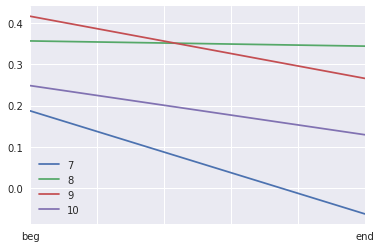

In [40]:
res.transpose().plot()

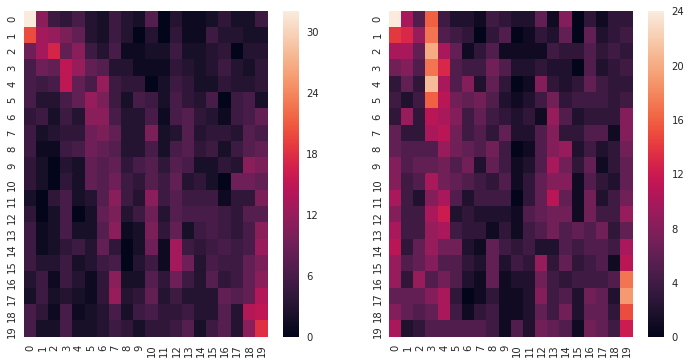

In [32]:
rat = 10
fig = plt.figure(figsize=(12,6))
plt.subplot(1,2,1)
sns.heatmap(res['beg'][rat])
plt.subplot(1,2,2)
sns.heatmap(res['end'][rat])

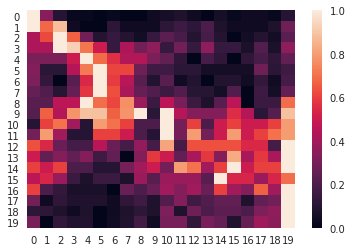

In [20]:
from spikeHelper.dataOrganization import normRows
sns.heatmap(normRows(res['beg'][9]))

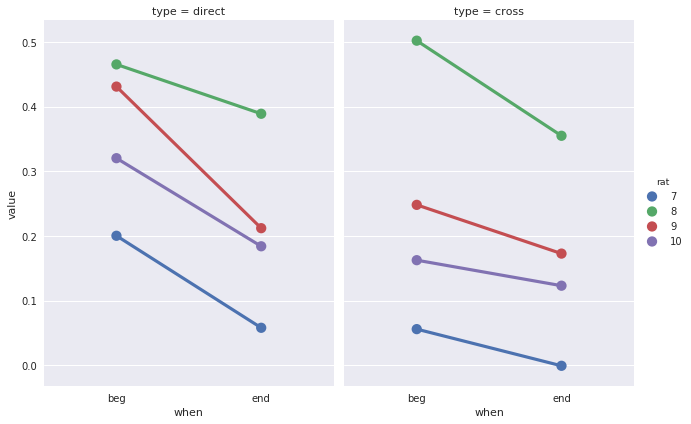

In [39]:
g = sns.factorplot( x="when", y="value", hue="rat", col="type", data=results,
                   capsize=.2, size=6, aspect=.75)
g.despine(left=True)

In [ ]:
ntrials = 100
results = pd.DataFrame(columns = ['when','type','rat','value'])
for rat in [7,8,9,10]:
    data = pickle.load(open('Data/r'+str(rat)+'_bin50_sigma100.pickle','rb'))
    data = XyTfromEpoch(data,getBins=[10,30], minBins= 36, maxBins = 86)
    print('Calculating for rat %d using %d trials and %d neurons' %(rat,data.shape[2],data.shape[0]))
    
    parameters = loadBestParams(rat)
    
    
    beg = trialToXyT(data[:,:,:ntrials])
    end = trialToXyT(data[:,:,-ntrials:])
    
    clf = SVC(kernel='rbf', C=parameters['C'], gamma=10**parameters['logGamma'])
    aux = temporalGeneralization(getX(beg), beg['y'], beg['trial'], clf,returnCubic=True)
    aux = performanceFromConfusion(aux)
    results= pd.concat((results,pd.DataFrame({'when':'beg','type':'direct','rat':rat,'value':aux},index=[rat])),axis=0) 
    
    clf = SVC(kernel='rbf', C=parameters['C'], gamma=10**parameters['logGamma'])
    aux = temporalGeneralization(getX(end), end['y'], end['trial'], clf,returnCubic=True)
    aux = performanceFromConfusion(aux)
    results= pd.concat((results,pd.DataFrame({'when':'end','type':'direct','rat':rat,'value':aux},index=[rat])),axis=0)
    

    cross = pd.DataFrame(columns=['confusion'],index = ['Rat 7','Rat 8','Rat 9', 'Rat 10'])

    aux, _ = crossGeneralization(beg,end,rat)
    aux = performanceFromConfusion(aux)
    results= pd.concat((results,pd.DataFrame({'when':'beg','type':'cross','rat':rat,'value':aux},index=[rat])),axis=0)
    aux, _ = crossGeneralization(end,beg,rat)
    aux = performanceFromConfusion(aux)
    results= pd.concat((results,pd.DataFrame({'when':'end','type':'cross','rat':rat,'value':aux},index=[rat])),axis=0)

# Evolução do desempenho dos classificadores treinados nas últimas tentativas

---